In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [55]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [56]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [57]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [58]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [59]:
def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [60]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns, erase_column):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        df = df.drop(erase_column, axis=1)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 2) #2 meses
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

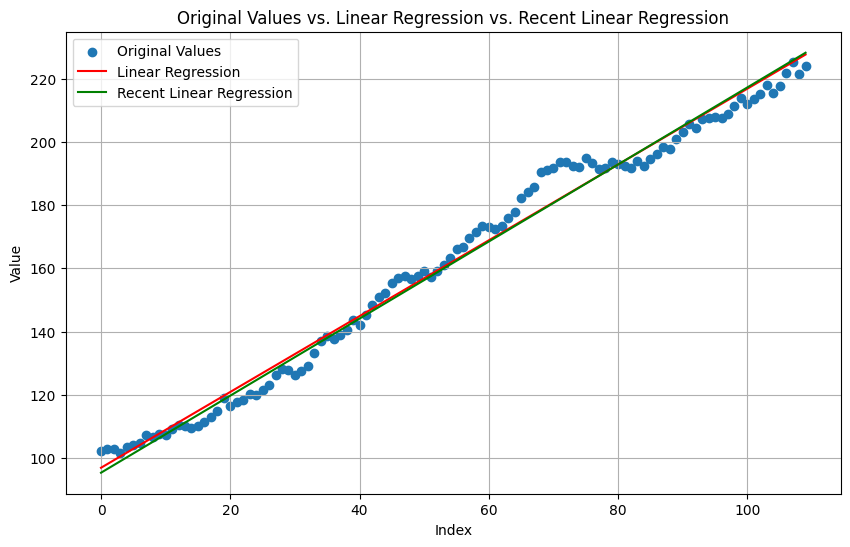

,Ano,PIB - Atividades imobiliárias (média 1995 = 100)
0,1996,102.660607
1,1996,102.515803
2,1996,102.652278
3,1996,102.910220
4,1997,103.606011
5,1997,104.558063
6,1997,105.347023
7,1997,106.259795
8,1998,106.589543
9,1998,107.373153


In [61]:
df = read_csv_replace_missing_by_polynomial('PIB - Atividade Imobiliarias.csv', 0, 0, 'Apagar')
df

In [62]:
def dataframe_expanded_interpolation(df):
    expanded_df = pd.DataFrame(columns=df.columns)
    for i, (_, row) in enumerate(df.iterrows()):
        if i > 0:
            expanded_df = pd.concat([expanded_df, pd.DataFrame(columns=df.columns, index=[None] * 2)])
        expanded_df = pd.concat([expanded_df, pd.DataFrame(row).T])
    expanded_df = expanded_df.reset_index(drop=True)
    expanded_df.interpolate(method='linear', axis=0, inplace=True)

    return expanded_df

def add_ano_column(df):
    new_df = df.copy()
    ano_start = 2002
    for i in range(len(new_df)):
        if i % 12 == 0:
            ano_start += 1
        new_df.at[i, 'Ano'] =  str(ano_start)

    return new_df

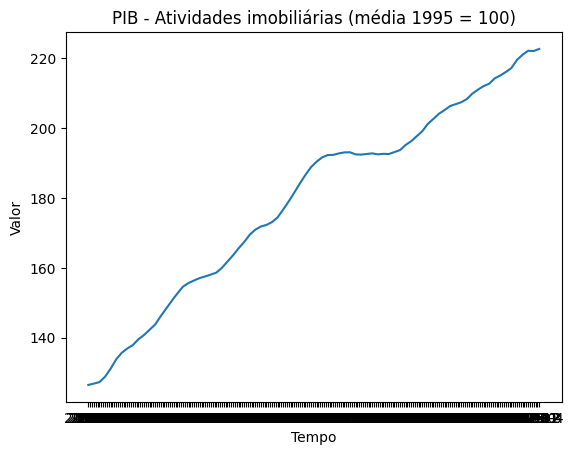

,PIB - Atividades imobiliárias (média 1995 = 100)
2003-1,126.459809
2003-2,126.581813
2003-3,126.703818
2003-4,126.825822
2003-5,126.976217
2003-6,127.126613
2003-7,127.277008
2003-8,127.785814
2003-9,128.294619
2003-10,128.803425


In [63]:
pd.set_option('display.max_rows', None)
df_2003 = df[df['Ano'] >= 2003]
df_mo_2003 = dataframe_expanded_interpolation(df_2003)
df_mo_2003 = add_ano_column(df_mo_2003)
df_mo_2003 = df_mo_2003.set_index('Ano', inplace=False)
df_mo_2003 = add_month(df_mo_2003)
plot_columns(df_mo_2003)
df_mo_2003

In [65]:
df_mo_2003.to_csv('2003_mo_pib_ativ_imob.csv', index=True)